In [ ]:
import gymnasium as gym
import gymnasium_robotics

gym.register_envs(gymnasium_robotics)

env = gym.make("FetchPickAndPlaceDense-v3")
#env = gym.make("FetchPickAndPlace-v3")  # sin render_mode
# env = gym.make("FetchPickAndPlace-v3", render_mode="human")  # con render_mode
obs, info = env.reset()

print("Observación:", obs.keys())
print("Espacio de acción:", env.action_space)
print("Espacio de observación:", env.observation_space)


Observación: dict_keys(['observation', 'achieved_goal', 'desired_goal'])
Espacio de acción: Box(-1.0, 1.0, (4,), float32)
Espacio de observación: Dict('achieved_goal': Box(-inf, inf, (3,), float64), 'desired_goal': Box(-inf, inf, (3,), float64), 'observation': Box(-inf, inf, (25,), float64))


In [ ]:
import matplotlib.pyplot as plt
import gymnasium as gym
import gymnasium_robotics

gym.register_envs(gymnasium_robotics)

env = gym.make("FetchPickAndPlace-v3", render_mode="rgb_array") 
#env = gym.make("FetchPickAndPlace-v3")  # sin render_mode
# env = gym.make("FetchPickAndPlace-v3", render_mode="human")  # con render_mode
obs, info = env.reset()

print("Observación:", obs.keys())
print("Espacio de acción:", env.action_space)
print("Espacio de observación:", env.observation_space)
frame = env.render()
plt.imshow(frame)
plt.axis("off")
plt.show()


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

class PolicyNetwork(nn.Module):
    def __init__(self, input_dim, action_dim):
        super().__init__()
        self.fc = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU()
        )
        self.mean = nn.Linear(64, action_dim)
        self.log_std = nn.Parameter(torch.zeros(action_dim))

    def forward(self, x):
        x = self.fc(x)
        return self.mean(x), self.log_std.expand_as(self.mean(x))

    def act(self, state):
        state = torch.tensor(state, dtype=torch.float32).to(device)
        mean, log_std = self.forward(state)
        std = torch.exp(log_std)
        dist = torch.distributions.Normal(mean, std)
        action = dist.sample()
        log_prob = dist.log_prob(action).sum()
        return action.cpu().detach().numpy(), log_prob


In [ ]:
def reinforce(env, policy, optimizer, episodes=500, gamma=0.99):
    rewards_history = []

    for episode in range(episodes):
        state, _ = env.reset()
        state = np.concatenate([state["observation"], state["desired_goal"]])

        log_probs = []
        rewards = []

        for _ in range(100):
            action, log_prob = policy.act(state)
            next_state, reward, terminated, truncated, _ = env.step(action)
            done = terminated or truncated

            next_state = np.concatenate([next_state["observation"], next_state["desired_goal"]])

            log_probs.append(log_prob)
            rewards.append(reward)

            state = next_state
            if done:
                break

        # Calcular retornos
        returns = []
        G = 0
        for r in reversed(rewards):
            G = r + gamma * G
            returns.insert(0, G)
        returns = torch.tensor(returns, dtype=torch.float32).to(device)

        # Normalizar retornos
        returns = (returns - returns.mean()) / (returns.std() + 1e-8)
        
        policy_loss = []
        for log_prob, R in zip(log_probs, returns):
            policy_loss.append(-log_prob * R)
        loss = torch.stack(policy_loss).sum()

        # Optimizar
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_reward = sum(rewards)
        rewards_history.append(total_reward)

        if episode % 10 == 0:
            print(f"Ep {episode}: Recompensa total = {total_reward:.2f}")

    return rewards_history


In [ ]:
# Dimensiones
obs_dim = env.observation_space["observation"].shape[0]
goal_dim = env.observation_space["desired_goal"].shape[0]
action_dim = env.action_space.shape[0]

policy = PolicyNetwork(input_dim=obs_dim + goal_dim, action_dim=action_dim).to(device)
optimizer = optim.Adam(policy.parameters(), lr=1e-3)

historia = reinforce(env, policy, optimizer, episodes=300)


Ep 0: Recompensa total = -42.93
Ep 10: Recompensa total = -21.88
Ep 20: Recompensa total = -22.79
Ep 30: Recompensa total = -23.43
Ep 40: Recompensa total = -30.58
Ep 50: Recompensa total = -36.04
Ep 60: Recompensa total = -21.55
Ep 70: Recompensa total = -26.92
Ep 80: Recompensa total = -25.20
Ep 90: Recompensa total = -21.50
Ep 100: Recompensa total = -38.94
Ep 110: Recompensa total = -24.48
Ep 120: Recompensa total = -25.78
Ep 130: Recompensa total = -38.31
Ep 140: Recompensa total = -43.87
Ep 150: Recompensa total = -38.04
Ep 160: Recompensa total = -35.53
Ep 170: Recompensa total = -37.12
Ep 180: Recompensa total = -21.34
Ep 190: Recompensa total = -22.68
Ep 200: Recompensa total = -28.21
Ep 210: Recompensa total = -31.97
Ep 220: Recompensa total = -35.00
Ep 230: Recompensa total = -26.60
Ep 240: Recompensa total = -21.65
Ep 250: Recompensa total = -21.57
Ep 260: Recompensa total = -21.75
Ep 270: Recompensa total = -32.44
Ep 280: Recompensa total = -34.39
Ep 290: Recompensa total 

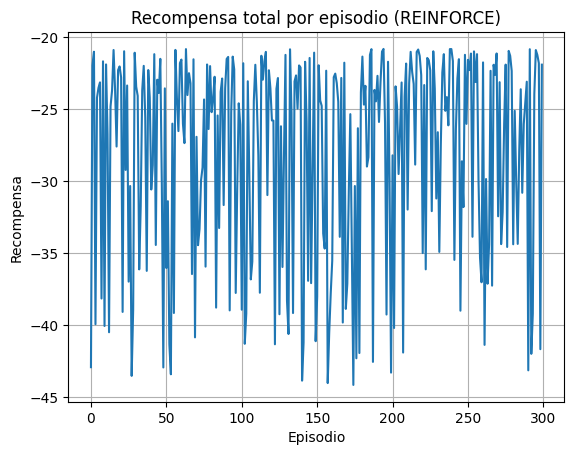

In [27]:
import matplotlib.pyplot as plt

plt.plot(historia)
plt.title("Recompensa total por episodio (REINFORCE)")
plt.xlabel("Episodio")
plt.ylabel("Recompensa")
plt.grid(True)
plt.show()
